<a href="https://colab.research.google.com/github/psukphranee/Python-Practice/blob/master/SAR_scratch_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [140]:
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import scipy.sparse as sp

#A. LFM Pulse

This section goes through the rundown of generating an LFM pulse. Dummy values are used. We define and visualize the pulse envelope and chirp separately and then we combine them by multiplying them together. 

### $P(t) = \chi_{\tau}(t) e^{j 2 \pi (f_c t + \frac{1}{2}k t^2)}$. (cite Cheney Here)

$\chi_{\tau}(t)$ piecewise function describing pulse envelope

$f_c$ = carrier frequency

$k$ = chirp rate


In [248]:
def generate_LFM_Pulse(time_array, pulse_width, pulse_height, chirp_rate=1, carrier_frequency=100):
  
  #time ---------------
  t = time_array.reshape(1,-1) #turn into row vector

  #pulse envelope  ---------------
  A = pulse_height;
  tau = pulse_width; 
  tau_half = tau/2;

  chi = A * (np.abs((t-tau_half)/tau_half) <= 1);
  #chi = generate_pulse_envelope(t, pulse_height, pulse_width);

  #LFM  ---------------
  k = chirp_rate
  f_c = carrier_frequency

  #argument to be passed to exponenetial 
  exp_arg = 2j*np.pi*(f_c*t + .5*k*(t**2))
  LFM = np.exp(exp_arg);

  pulse = chi*LFM
  return pulse

def plot_pulse(time, pulse, fig, ax, **kwargs):
  t=time;
  pulse=pulse;

  ax.plot(t, np.real(pulse), alpha=0.4, *kwargs)
  plt.xlim([t[0],t[-1]])
  plt.show()

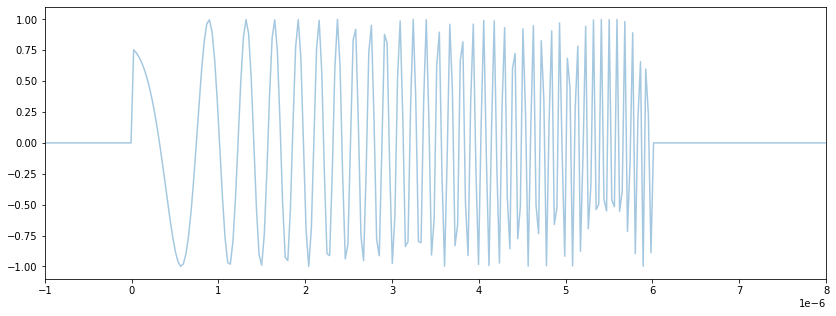

In [249]:
PRF = 500 #GHz
tau = 6e-6 #seconds
f_c = 1e10
bandwidth = 20 #Ghz
k = 2e12

t = np.linspace(-1e-6,8e-6, 300).reshape(1,-1)

pulse = generate_LFM_Pulse(t, pulse_width=tau, pulse_height=1, carrier_frequency=f_c, chirp_rate=k )
# pulse2 = generate_LFM_Pulse(t, 1, 1, 20, 1e9)
# pulse3 = generate_LFM_Pulse(t, 2, 1, 20, 1e9)

fig, ax = plt.subplots(figsize=(14,5))
plot_pulse(t[0], pulse[0], fig=fig, ax=ax)


In [246]:
t.shape

(1, 300)

#B. Convolution as a Matrix



1.   Create Identity Matrix, A, of dimension NxN
2.   Determine index step interval of elements to sample, Di. We have to take into consideration the differences in time-steps between the signal matrix and our time delay matrix that corresponds to the ground subintervals. 

Let $dt_g$ be the time delay between each ground subinterval and let $dt_s$ the time-step from the signal. Then we can estimate the indices for our convolution matrix accordingly. Our spacing for the indices can be approximated by dividing the $\frac{dt_g(furthest) - dt_g(closest)}{dt_s}$.

3.   Create the Convolution Matrix, B, consisting of zeros and dimension NxN
4.   Loop through and shift each rows of identity matrix A by amount Di along. Add the result of this shift to B.
5.   Return upper triangular part of B.



##1. Define Function

define function that returns a convolution matrix. make sparse later for performance.

In [350]:
def return_Convolution_Matrix(time_matrix, delay_matrix):
  #time_matrix is vector of time correspoding to the signal
  #delay_matrix vector of time delay values corresponding to ground elements

  N = time_matrix.shape[0]
  num_ground_points = delay_matrix.shape[0]
  time_matrix_interval = (time_matrix[0, -1] - time_matrix[0, 0])/t.shape[1]

  I_N = np.eye(N)
  Convolution_Matrix = np.zeros((N, N))
  delay_matrix = delay_matrix - delay_matrix[0,0] #offset values

  for i in range(0, num_ground_points):
    curr_index = delay_matrix[0, i]/time_matrix_interval

    Convolution_Matrix = Convolution_Matrix + np.roll(I_N, curr_index, axis=1)

  Convolution_Matrix = np.triu(Convolution_Matrix)

  return Convolution_Matrix;

0
1
2
3
4


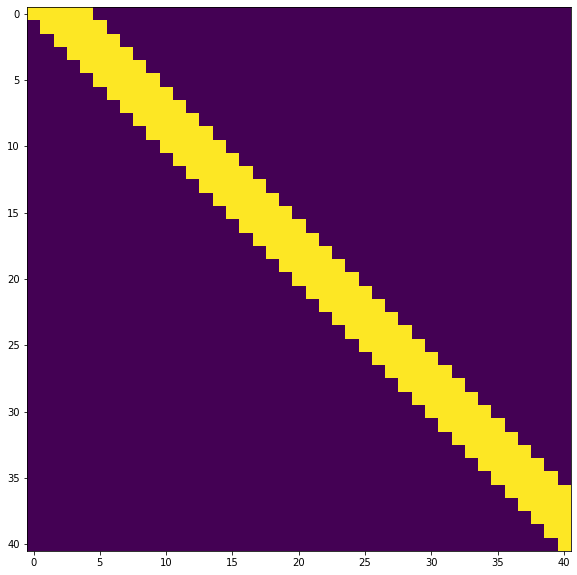

In [377]:
time_matrix = np.linspace(0,10,41).reshape(1,-1)
delay_matrix = np.linspace(0, 1, 5).reshape(1,-1)

N = time_matrix.shape[1]
num_ground_points = delay_matrix.shape[1]
time_matrix_interval = (time_matrix[0, -1] - time_matrix[0, 0])/t.shape[1]

# print(N, num_ground_points, time_matrix_interval)

I_N = np.eye(N)
Convolution_Matrix = np.zeros((N, N))
delay_matrix = delay_matrix - delay_matrix[0,0] #offset values

# print(I_N.shape)

for i in range(0, num_ground_points):
  curr_index = (delay_matrix[0, i]/time_matrix_interval).astype(int)
  print(curr_index)
  Convolution_Matrix = Convolution_Matrix + np.roll(I_N, curr_index, axis=1)

Convolution_Matrix = np.triu(Convolution_Matrix)

# print(t)
# print(d)
# print(Convolution_Matrix)

plt.figure(figsize=(10,10))
plt.imshow(Convolution_Matrix)

In [279]:
def return_Convolution_Matrix(dimension, step, num_points):
  N = dimension
  A = np.eye(N)
  Convolution_Matrix = np.zeros((N, N))

  for i in range(0, num_points, Di):
    Convolution_Matrix = Convolution_Matrix + np.roll(A, i, axis=1)

  Convolution_Matrix = np.triu(Convolution_Matrix)

  return Convolution_Matrix;

### a. Test Function
Operate on dummy vector and sum. 

In [251]:
test_t = np.linspace(0,5,5).reshape(1,-1) #row vector
test_p = np.array([0,1,0,1,0]).reshape(1,-1) #row vector

N = test_t.shape[1]
Di = 2

conv_mat = return_Convolution_Matrix(dimension=N, step=Di)
print("N=", N)
print(conv_mat, '\n\n', test_p, '\n\n', np.matmul(conv_mat, test_p.transpose()))

N= 5
[[1. 0. 1. 0. 1.]
 [0. 1. 0. 1. 0.]
 [0. 0. 1. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]] 

 [[0 1 0 1 0]] 

 [[0.]
 [2.]
 [0.]
 [1.]
 [0.]]


In [209]:
rect = np.ones((1,5))
print(rect.shape)

np.matmul(conv_mat, rect.transpose())

(1, 5)


array([[3.],
       [2.],
       [2.],
       [1.],
       [1.]])

##2. Test on Pulse 

In [257]:
N = pulse.shape[1]
Di = 5#step interval (wrt to indices)

Pulse_Convolution = return_Convolution_Matrix(dimension=N, step=Di)

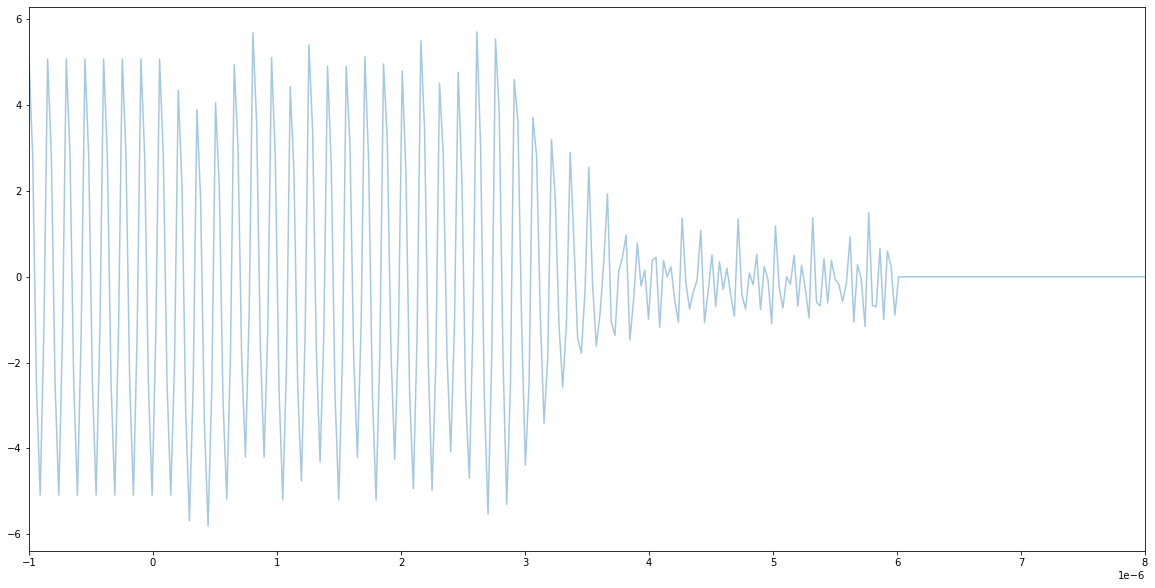

In [278]:
result = np.matmul(Pulse_Convolution, pulse.transpose())

fig, ax = plt.subplots(figsize=(20,10))
plot_pulse(t[0], result, fig=fig, ax=ax)

In [265]:
result.shape

(300, 1)

In [266]:
t.shape

(1, 300)